In [137]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt

# Import data

In [138]:
# file path to data folder
path = './Output'

In [139]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

In [140]:
data

,subjectID,date,ActivityCounts,Barometer,BloodPerfusion,BloodPulseWave,EnergyExpenditure,GalvanicSkinResponse,HR,HRV,...,Steps,SkinTemperature,ActivityClass,timezone,VAS,phF,MF,ReIP,sport,n_answers
0,1,14.03.19,"0.784313725,1.176470588,2.352941176,1.17647058...","981.25,981.2,981.2,981.1,981.2,981.3,981.2,981...","0.0,0.175,0.19,0.11,0.1,0.09,None,None,None,No...","0.0,1.9,1.82,1.94,1.68,1.09,None,None,None,Non...","753.6365662,1256.060944,1256.060944,1256.06094...","None,None,None,None,None,None,None,None,None,N...","83.0,75.40363269,69.11265332,69.78116438,72.30...","None,None,None,None,None,None,None,None,None,N...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0...","28.28,29.44,30.41,31.0,31.455,31.795,32.22,31....","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,0.0,1.0,-1.0,0.0,1
1,1,15.03.19,"0.784313725,0.784313725,0.784313725,0.78431372...","984.4,984.5,984.3,984.4,984.3,984.4,984.3,984....","0.875,0.825,0.975,0.98,1.0,0.985,0.96,0.93,0.9...","2.27,2.18,2.19,2.18,2.02,2.27,2.27,2.49,2.17,2...","1311.85318,1311.85318,1311.85318,1311.85318,13...","2.471338889,2.46735,2.466372222,2.4621,2.45465...","67.54923531,57.26287697,55.2253739,58.43175416...","44.92312073,51.26666667,57.7,58.01666667,57.41...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","36.13,36.19,36.25,36.31,36.44,36.5,36.59,36.69...","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,1.0,1.0,1.0,1.0,1
2,1,16.03.19,"0.784313725,1.176470588,5.098039216,0.78431372...","990.7,990.6,990.7,990.7,990.8,990.75,990.8,990...","1.045,0.79,0.84,0.585,0.415,0.74,0.835,0.835,0...","2.32,2.22,2.44,2.18,2.45,2.44,2.24,2.28,2.18,2...","1311.85318,1311.85318,1311.85318,1311.85318,13...","1.172788889,1.171305556,1.061122222,3.09794444...","64.65655738,63.83929024,63.86047157,62.6129328...","31.3815721,34.48333333,36.25,39.48333333,41.9,...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","34.34,34.38,34.38,34.455,34.16,34.06,34.19,34....","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,0.0,0.0,0.0,0.0,1
3,1,17.03.19,"0.784313725,0.784313725,0.784313725,0.78431372...","982.15,982.05,982.0,982.0,982.0,982.0,982.0,98...","1.42,1.47,1.48,1.46,1.49,1.475,1.47,1.46,1.45,...","2.86,2.7,2.73,2.72,2.68,2.9,2.96,3.02,3.08,3.3...","1311.85318,1311.85318,1311.85318,1311.85318,13...","2.573777778,2.567694444,2.560622222,2.55622222...","69.66641006,70.49757838,70.17700916,69.3862999...","23.08598131,22.81666667,20.41666667,20.5166666...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","35.63,35.63,35.44,35.41,35.38,35.38,35.38,35.3...","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,1.0,0.0,0.0,1.0,1
4,1,18.03.19,"0.784313725,1.176470588,0.784313725,0.78431372...","988.5,988.6,988.7,988.65,988.5,988.5,988.5,988...","1.48,1.49,1.155,1.525,1.38,1.45,1.555,1.41,1.6...","1.54,1.61,2.18,2.01,1.76,1.76,1.78,1.81,1.5,1....","1289.98896,1311.85318,1311.85318,1311.85318,13...","2.632423729,2.630555556,2.626594444,2.62318333...","57.42528736,59.38585964,65.7858185,58.39290306...","33.69491525,34.18333333,37.91988636,46.85,52.9...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","36.94,36.97,36.97,36.69,36.53,36.34,36.19,35.9...","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,1.0,0.0,-1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,27,24.08.18,"None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...",...,"None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...","None,None,None,None,None,None,None,None,None,N...",CEST,0.0,1.0,1.0,0.0,NaN,2
406,27,26.08.18,"N

In [141]:
data.dtypes

subjectID                 int64
date                     object
ActivityCounts           object
Barometer                object
BloodPerfusion           object
BloodPulseWave           object
EnergyExpenditure        object
GalvanicSkinResponse     object
HR                       object
HRV                      object
RESP                     object
Steps                    object
SkinTemperature          object
ActivityClass            object
timezone                 object
VAS                     float64
phF                     float64
MF                      float64
ReIP                    float64
sport                    object
n_answers                 int64
dtype: object

In [142]:
query = '''
SELECT *
FROM data
WHERE subjectID = 1
'''
temp = sqldf(query)
temp

,subjectID,date,ActivityCounts,Barometer,BloodPerfusion,BloodPulseWave,EnergyExpenditure,GalvanicSkinResponse,HR,HRV,...,Steps,SkinTemperature,ActivityClass,timezone,VAS,phF,MF,ReIP,sport,n_answers
0,1,14.03.19,"0.784313725,1.176470588,2.352941176,1.17647058...","981.25,981.2,981.2,981.1,981.2,981.3,981.2,981...","0.0,0.175,0.19,0.11,0.1,0.09,None,None,None,No...","0.0,1.9,1.82,1.94,1.68,1.09,None,None,None,Non...","753.6365662,1256.060944,1256.060944,1256.06094...","None,None,None,None,None,None,None,None,None,N...","83.0,75.40363269,69.11265332,69.78116438,72.30...","None,None,None,None,None,None,None,None,None,N...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0...","28.28,29.44,30.41,31.0,31.455,31.795,32.22,31....","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,0.0,1.0,-1.0,0.0,1
1,1,15.03.19,"0.784313725,0.784313725,0.784313725,0.78431372...","984.4,984.5,984.3,984.4,984.3,984.4,984.3,984....","0.875,0.825,0.975,0.98,1.0,0.985,0.96,0.93,0.9...","2.27,2.18,2.19,2.18,2.02,2.27,2.27,2.49,2.17,2...","1311.85318,1311.85318,1311.85318,1311.85318,13...","2.471338889,2.46735,2.466372222,2.4621,2.45465...","67.54923531,57.26287697,55.2253739,58.43175416...","44.92312073,51.26666667,57.7,58.01666667,57.41...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","36.13,36.19,36.25,36.31,36.44,36.5,36.59,36.69...","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,1.0,1.0,1.0,1.0,1
2,1,16.03.19,"0.784313725,1.176470588,5.098039216,0.78431372...","990.7,990.6,990.7,990.7,990.8,990.75,990.8,990...","1.045,0.79,0.84,0.585,0.415,0.74,0.835,0.835,0...","2.32,2.22,2.44,2.18,2.45,2.44,2.24,2.28,2.18,2...","1311.85318,1311.85318,1311.85318,1311.85318,13...","1.172788889,1.171305556,1.061122222,3.09794444...","64.65655738,63.83929024,63.86047157,62.6129328...","31.3815721,34.48333333,36.25,39.48333333,41.9,...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","34.34,34.38,34.38,34.455,34.16,34.06,34.19,34....","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,0.0,0.0,0.0,0.0,1
3,1,17.03.19,"0.784313725,0.784313725,0.784313725,0.78431372...","982.15,982.05,982.0,982.0,982.0,982.0,982.0,98...","1.42,1.47,1.48,1.46,1.49,1.475,1.47,1.46,1.45,...","2.86,2.7,2.73,2.72,2.68,2.9,2.96,3.02,3.08,3.3...","1311.85318,1311.85318,1311.85318,1311.85318,13...","2.573777778,2.567694444,2.560622222,2.55622222...","69.66641006,70.49757838,70.17700916,69.3862999...","23.08598131,22.81666667,20.41666667,20.5166666...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","35.63,35.63,35.44,35.41,35.38,35.38,35.38,35.3...","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,1.0,0.0,0.0,1.0,1
4,1,18.03.19,"0.784313725,1.176470588,0.784313725,0.78431372...","988.5,988.6,988.7,988.65,988.5,988.5,988.5,988...","1.48,1.49,1.155,1.525,1.38,1.45,1.555,1.41,1.6...","1.54,1.61,2.18,2.01,1.76,1.76,1.78,1.81,1.5,1....","1289.98896,1311.85318,1311.85318,1311.85318,13...","2.632423729,2.630555556,2.626594444,2.62318333...","57.42528736,59.38585964,65.7858185,58.39290306...","33.69491525,34.18333333,37.91988636,46.85,52.9...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","36.94,36.97,36.97,36.69,36.53,36.34,36.19,35.9...","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,1.0,0.0,-1.0,1.0,1
5,1,20.03.19,"0.784313725,0.784313725,0.784313725,0.78431372...","1002.0,1001.9,1001.95,1002.0,1002.0,1002.0,100...","1.27,1.55,1.49,1.515,1.5,1.48,1.485,1.46,1.45,...","2.0,1.87,1.96,1.92,1.9,1.84,1.9,1.99,1.96,1.89...","1311.85318,1311.85318,1311.85318,1311.85318,13...","None,None,None,None,None,None,None,None,None,N...","52.63032548,53.35165125,50.74380601,50.8068331...","64.95,65.5,67.45484509,66.46666667,60.66617575...",...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","35.72,35.56,35.36,35.19,35.0,34.84,34.75,34.59...","None,None,None,None,None,None,None,None,None,N...",UTC,0.0,1.0,1.0,-1.0,1.0,1
6,1,21.03.19,"0.784313725,0.784313725,0.784313725,0.78431372...","1003.5,1003.5,1003.5,1003.6,1003.6,1003.6,1

In [162]:
query = '''
SELECT LENGTH(GalvanicSkinResponse), LENGTH(HR)
FROM data
WHERE subjectID = 1
'''
sqldf(query)

,LENGTH(GalvanicSkinResponse),LENGTH(HR)
0,5516,6444
1,15465,16442
2,15028,16393
3,14706,15739
4,13812,16401
5,11767,16357
6,8078,9199


In [150]:
variable = 'GalvanicSkinResponse'
day = 0
temp[variable][day]

'None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,4.989619048,4.953446328,4.859005556,4.778458333,4.698305556,4.636927778,4.555288889,4.498311111,4.449088889,4.408044444,4.362577778,4.306955556,4.267272222,4.225116667,4.182605556,4.145922222,4.106411111,4.072061111,4.035955556,3.996311111,3.96515,3.933944444,3.900172222,3.865761111,3.837005556,3.805561111,3.775416667,3.742994444,3.716866667,3.689966667,3.663227778,3.636727778,3.615378531,3.590727778,3.571861111,3.551438889,3.531366667,3.511011111,3.494727778,3.4777,3.462511111,3.448311111,3.429338889,3.414605556,3.402805556,3.388216667,3.375933333,3.361061111,3.347322222,3.334805556,3.320388889,3.3094,3.297827778,3.2823,3.271977778,3.259433333,3.246294444,3.235933333,3.223722222,3.213644444,3.203177778,3.191961111,3.182655556,3.171633333,3.164038889,3.152238889,3.140277778,3.134644444,3.121205556,3.111516667,3.102677778,3

In [151]:
'None' in temp[variable][day]

True

In [164]:
len(temp[variable][day].split(','))

562

In [155]:
temp[variable][day].split(',')

['None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 '4.989619048',
 '4.953446328',
 '4.859005556',
 '4.778458333',
 '4.698305556',
 '4.636927778',
 '4.555288889',
 '4.498311111',
 '4.449088889',
 '4.408044444',
 '4.362577778',
 '4.306955556',
 '4.267272222',
 '4.225116667',
 '4.182605556',
 '4.145922222',
 '4.106411111',
 '4.072061111',
 '4.035955556',
 '3.996311111',
 '3.96515',
 '3.933944444',
 '3.900172222',
 '3.865761111',
 '3.837005556',
 '3.805561111',
 '3.775416667',
 '3.742994444',
 '3.716866667',
 '3.689966667',
 '3.663227778',
 '3.636727778',
 '3.615378531',
 '3.590727778',
 '3.571861111',
 '3.551438889',
 '3.531366667',
 '3.511011111',
 '3.494727778',
 '3.4777',
 '3.462511111',
 '3.448311111',
 '3.429338889',
 '3.414605556',
 '3.4028

In [166]:
len([value if value != 'None' else None for value in temp[variable][day].split(',')])

562

In [159]:
[value if value != 'None' else None for value in temp[variable][day].split(',')]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '4.989619048',
 '4.953446328',
 '4.859005556',
 '4.778458333',
 '4.698305556',
 '4.636927778',
 '4.555288889',
 '4.498311111',
 '4.449088889',
 '4.408044444',
 '4.362577778',
 '4.306955556',
 '4.267272222',
 '4.225116667',
 '4.182605556',
 '4.145922222',
 '4.106411111',
 '4.072061111',
 '4.035955556',
 '3.996311111',
 '3.96515',
 '3.933944444',
 '3.900172222',
 '3.865761111',
 '3.837005556',
 '3.805561111',
 '3.775416667',
 '3.742994444',
 '3.716866667',
 '3.689966667',
 '3.663227778',
 '3.636727778',
 '3.615378531',
 '3.590727778',
 '3.571861111',
 '3.551438889',
 '3.531366667',
 '3.511011111',
 '3.494727778',
 '3.4777',
 '3.462511111',
 '3.448311111',
 '3.429338889',
 '3.414605556',
 '3.402805556',
 '3.388216667',
 '3.375933333',
 '3.361061111',
 '3.347322

In [160]:
np.array([value if value != 'None' else None for value in temp[variable][day].split(',')], dtype=float)

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 4.98961905, 4.95344633,
       4.85900556, 4.77845833, 4.69830556, 4.63692778, 4.55528889,
       4.49831111, 4.44908889, 4.40804444, 4.36257778, 4.30695556,
       4.26727222, 4.22511667, 4.18260556, 4.14592222, 4.10641111,
       4.07206111, 4.03595556, 3.99631111, 3.96515   , 3.93394444,
       3.90017222, 3.86576111, 3.83700556, 3.80556111, 3.77541667,
       3.74299444, 3.71686667, 3.68996667, 3.66322778, 3.63672778,
       3.61537853, 3.59072778, 3.57186111, 3.55143889, 3.53136667,
       3.51101111, 3.49472778, 3.4777    , 3.46251111, 3.44831

In [ ]:
plt.plot(np.array(temp[variable][day].split(','), dtype=float))

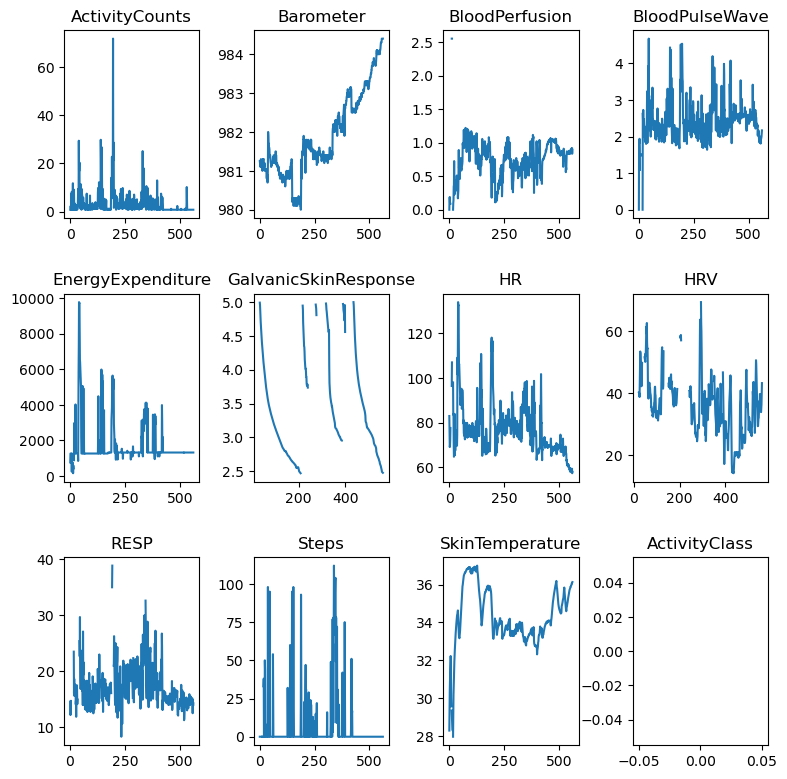

In [171]:
day = 0
variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']
plt.figure()
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=1.5,
                    wspace=0.4,
                    hspace=0.4)
length = len(np.array([value if value != 'None' else None for value in temp['HR'][day].split(',')], dtype=float))
for i, variable in enumerate(variables):
    time_series = np.array([value if value != 'None' else None for value in temp[variable][day].split(',')], dtype=float)

    assert len(time_series) == length, 'time-series data lengths differ!'

    plt.subplot(3, 4, i+1)
    plt.title(variable)
    plt.plot(time_series)

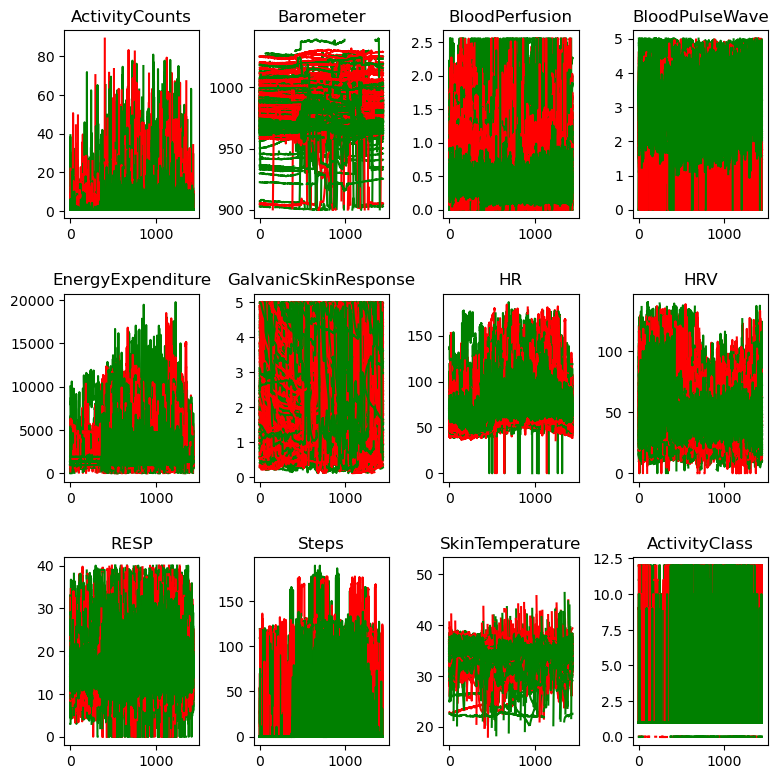

In [190]:
def plotter(figure, day):
    variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
                 'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
                 'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in data['HR'][day].split(',')], dtype=float))
    for i, variable in enumerate(variables):
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if data['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)

fig = plt.figure()
for day in range(data.shape[0]):
    plotter(fig, day)

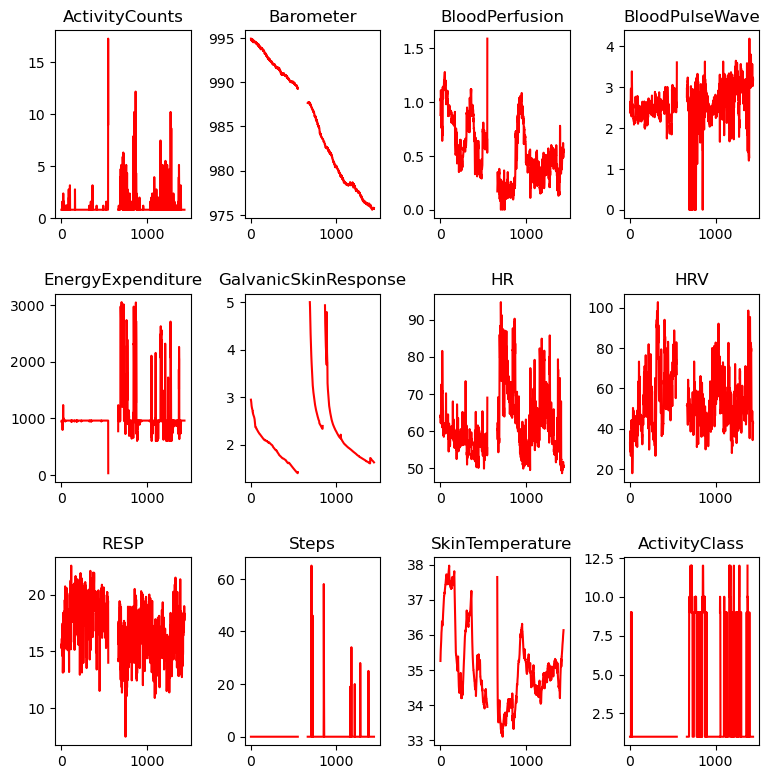

In [204]:
import random

def plotter(figure, day):
    variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
                 'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
                 'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in data['HR'][day].split(',')], dtype=float))
    for i, variable in enumerate(variables):
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if data['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)

fig = plt.figure()
day = random.sample(range(data.shape[0]), 1)[0]
plotter(fig, day)

C:\Users\jjung\anaconda3\envs\ai\lib\site-packages\matplotlib\axes\_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


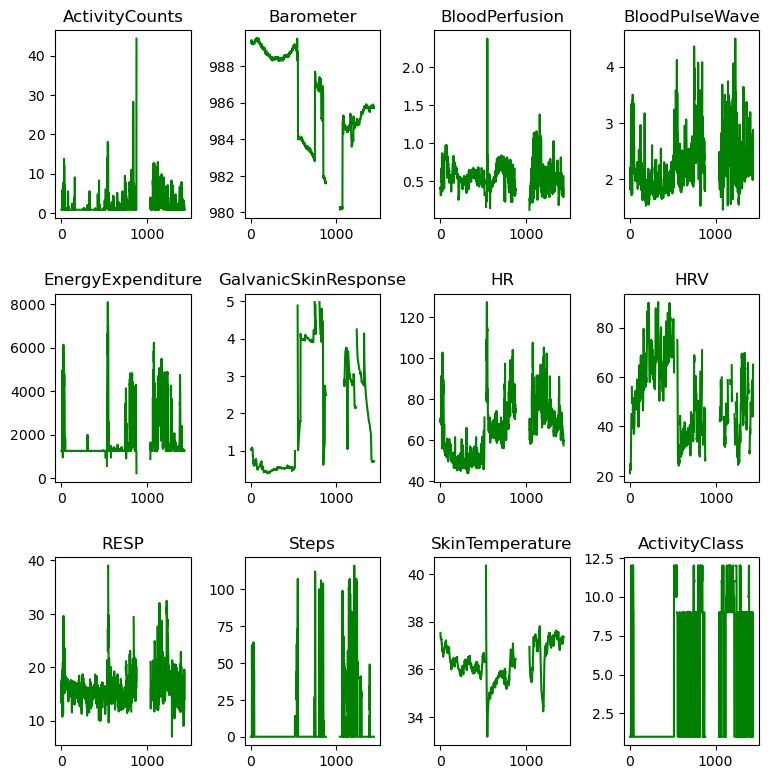

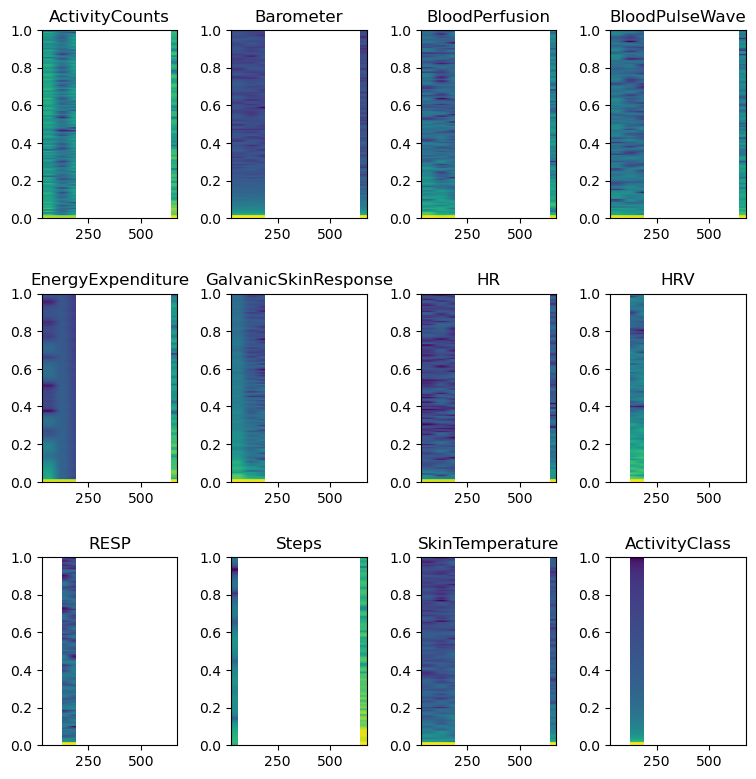

In [211]:
import random

def plotter(figure, day):
    variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
                 'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
                 'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in data['HR'][day].split(',')], dtype=float))
    for i, variable in enumerate(variables):
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if data['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)

def plotter_spec(figure, day):
    variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
                 'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
                 'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in data['HR'][day].split(',')], dtype=float))
    for i, variable in enumerate(variables):
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        assert len(time_series) == length, 'time-series data lengths differ!'

        plt.subplot(3, 4, i+1)
        plt.title(variable)

        plt.specgram(time_series)

day = random.sample(range(data.shape[0]), 1)[0]

fig = plt.figure()
plotter(fig, day)

fig = plt.figure()
plotter_spec(fig, day)